# Models

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms
from firthlogist import FirthLogisticRegression

import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, truncnorm
from scipy.stats import beta

from tqdm.notebook import tqdm


class QLearningModule:
    def __init__(self, *args, **kwargs):
        self.lr = kwargs.get('lr', .5)
        self.rl_temp = kwargs.get('rl_temp', 1)
        n_states, n_actions = kwargs.get(
            'n_states', 2), kwargs.get('n_actions', 2)
        self.q = np.ones((n_states, n_actions)) * kwargs.get('q0', 50)

    def value_update(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualLogit:
    def __init__(self, *args, **kwargs):
        self.perceptual_temp = kwargs.get('perceptual_temp', 1)
        self.perceptual_model = kwargs.get('perceptual_model', 'logit')
        self.x = kwargs.get('x', np.arange(-1, 1, .2))

        self.firth_fit = None
        self.logit_fit = None
        # history of forcefields
        self.hist_ff = []
        # history of rewards (destroyed or not)
        self.hist_r = []

    def predictff(self, ff1=None, ff2=None):

        model = self.perceptual_model

        if ff1 is not None and ff2 is not None:
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])
        else:
            # to_select = np.arange(len(self.x))
            to_select = np.arange(len(np.unique(self.hist_ff)))
        if model == 'logit':
            try:
                self.logit_fit = sm.Logit(self.hist_r, sm.add_constant(self.hist_ff))\
                    .fit_regularized(disp=0, start_params=[0, 0])

                return self.logit_fit.predict(sm.add_constant(self.x))[to_select]
            # catch separation error and value errrors
            except (sms.tools.sm_exceptions.PerfectSeparationError,
                    ValueError, np.linalg.LinAlgError):
                # equal probability for all forcefields
                try:
                    return 1/len(to_select) * np.ones(len(to_select))
                except ZeroDivisionError:
                    return

        elif model == 'firth':
            try:
                self.firth_fit = FirthLogisticRegression(skip_ci=True, wald=False, fit_intercept=True)\
                    .fit(sm.add_constant(self.hist_ff), self.hist_r)
                return self.firth_fit.predict(sm.add_constant(np.unique(self.hist_ff)))[to_select]
            except:
                return 1/len(to_select) * np.ones(len(to_select))
        else:
            raise ValueError(
                'model must be either logit, firth, or val. Model is {}'.format(model))

    def get_intercept_and_slope(self):
        model = self.perceptual_model
        if model == 'logit':
            if self.logit_fit is None:
                self.predictff()
                if self.logit_fit is None:
                    return np.array([0, 0])
            return np.clip(self.logit_fit.params, -10, 10)
        # elif model=='linear':
            # return
        elif model == 'firth':
            return np.array(self.firth_fit.coef_)
        elif model == 'val':
            return self.val_fit
        else:
            raise ValueError('model must be either logit or linear')


class LogitRLEV(PerceptualLogit, QLearningModule):
    def __init__(self, *args, **kwargs):
        PerceptualLogit.__init__(self, *args, **kwargs)
        QLearningModule.__init__(self, *args, **kwargs)

    def make_choice(self, s, ff1, ff2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        pdestroy = 1

        if ff1 is not None and ff2 is not None:
            pdestroy = self.predictff(ff1=ff1, ff2=ff2)

        x = ((self.q[s, :] * self.rl_temp)
             * (pdestroy
             * self.perceptual_temp))

        p = np.exp(x - logsumexp(x)).round(3)

        return np.random.choice(np.arange(2), p=p)

    def learn_perceptual(self, a, r):
        self.hist_ff.append(a)
        self.hist_r.append(r)
        self.predictff()

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        intercept, slope = self.get_intercept_and_slope()
        return {
            # alpha logit (utf8 character symbol as key)
            'α': intercept,
            # beta logit
            'β': slope,
            # alpha qlearning
            'lr': self.lr,
            # temperature qlearning
            'rl_temp': self.rl_temp,
            # temperature logit
            'perceptual_temp': self.perceptual_temp
        }


class RLLogitLogRatio(QLearningModule, PerceptualLogit):
    def __init__(self, *args, **kwargs):
        QLearningModule.__init__(self, *args, **kwargs)
        PerceptualLogit.__init__(self, *args, **kwargs)

    def make_choice(self, s, ff1, ff2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x1 = np.log(self.q[s, :]) * self.rl_temp
        x2 = np.log(self.predictff(ff1=ff1, ff2=ff2)) * self.perceptual_temp
        x = x1 + x2

        p = np.exp(x - logsumexp(x))

        try:
            return np.random.choice(np.arange(2), p=p)
        except ValueError as e:
            print(e)
            return np.random.choice(np.arange(2), p=[0.5, 0.5])


class NormativePerceptual:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        # slope prior
        self.slope_prior = kwargs.get('slope_prior', 2)
        # leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.arange(-1, 1, 10))

        # possible values for the slope
        self.slope_range = kwargs.get(
            'slope_range', np.arange(-10, 10, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # define logit function
        self.logit = lambda x: 1 / (1+np.exp(x))

    def perceptual_update(self, choice, destroyed):
        v = -self.slope_range*choice if destroyed else self.slope_range*choice
        # compute log likelihood
        ll = np.log(self.logit(v))
        # update log posterior
        self.lp_slope += ll
        self._apply_leak_perceptual()

    def predictff(self, ff1=None, ff2=None):
        if ff1 is None and ff2 is None:
            # predict p(destroy) for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # predict p(destroy) for 2 (displayed) forcefields
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])

        return self.logit(-self.get_slope()*self.x[to_select])

    def get_slope(self):
        w = np.exp(self.lp_slope-np.max(self.lp_slope))
        slope = np.sum(w*self.slope_range)/np.sum(w)
        return slope
    #

    def _apply_leak_perceptual(self):
        self.lp_slope *= 1-self.leak


class NormativeValue:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        self.sigma_prior = kwargs.get('sigma_prior', .2)
        self.std_prior = kwargs.get('std_prior', .2)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)

        # possible values for the difference between two options
        self.sigma_range = kwargs.get('sigma_range', np.arange(-1, 1, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_sigma = [
            np.log(tnormpdf(0.5*(1+self.sigma_range), 0.5, self.sigma_prior))
            for _ in range(self.nstate)
        ]

    def value_update(self, s, a, r):
        v = 1-self.sigma_range if a else 1+self.sigma_range
        # compute log likelihood
        ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
        # update log posterior
        self.lp_sigma[s] += ll
        self._apply_leak_value(s)

    def get_sigma(self, s):
        w = np.exp(self.lp_sigma[s]-np.max(self.lp_sigma[s]))
        sigma = np.sum(w*self.sigma_range)/np.sum(w)
        return sigma

    def _apply_leak_value(self,s):
        self.lp_sigma[s] *= 1-self.leak


class Normative(NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        NormativeValue.__init__(self, *args, **kwargs)
        NormativePerceptual.__init__(self, *args, **kwargs)

        self.temp = kwargs.get('temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        # default is EV decision
        p = self.predictff(ff1, ff2) if ff1 is not None else 1
        ev1, ev2 = ((.5 * (1+self.get_sigma(s)*(np.array([1, -1])))) * p).round(3)
        choice = np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2)))
        return choice

    def learn_perceptual(self, a, r):
        self.perceptual_update(a, r)

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        return {
            # beta logit (utf8 character symbol as key)
            'β': self.get_slope(),
            # sigma (diff between two options) (utf8 character symbol as key)
            'σ': self.get_sigma(s) if s is not None
            else [self.get_sigma(s) for s in range(self.nstate)],
        }


class NormativeEV(Normative,
                       NormativeValue, NormativePerceptual):
    pass


class NormativeLogRatio(Normative,
                             NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        p = np.log(self.predictff(ff1, ff2)) if ff1 is not None else 1
        ev = np.log(
            (.5 * (1+self.get_sigma(s)*(np.array([1, -1]))).round(3))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum().round(3)
        choice = int(np.random.random() > 1/(1+np.exp(-x)))
        return choice


class RandomModel:
    def __init__(self, *args, **kwargs):
        pass

    @staticmethod
    def make_choice(s, ff1, ff2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def learn_perceptual(a, r):
        pass

    @staticmethod
    def learn_value(s, a, r):
        pass

    @staticmethod
    def get_params(s=None):
        pass


def tnormpdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p


def tnormpdf2(x, loc, std, lb=0, ub=1):
    # TODO: check why it doesn't work
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc).pdf(x)


def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc, scale=std).rvs(size=size)
    


# Perceptual update

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

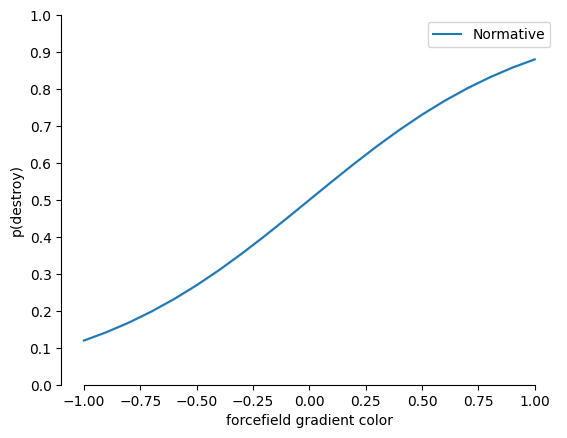

In [2]:
# -----------------------------------------------------------------
# simulation perceptual training
# -----------------------------------------------------------------
# hyperparameters
ntrial = 300
nagent = 20
models = (Normative, )#LogitRLEV)

# env parameters
ff_values = np.linspace(-1, 1, 100).round(1)

# model parameters
true_slope = 2
temperature = 1e6
true_leak = 0

normative_param = dict(slope_prior=true_slope, temp=temperature, leak=true_leak, x=ff_values)
hybrid_param = dict(perceptual_temp=temperature, perceptual_model='logit', x=ff_values,
    lr=.5, rl_temp=5, n_states=2, n_actions=2, q0=.5)

params = (normative_param, hybrid_param)

# forcefield chosen by the subject
ff = np.repeat(ff_values, ntrial/len(ff_values)).flatten()
# rewards (1 if target destroyed, 0 otherwise)
rff = np.random.random(ntrial) < 1/(1+np.exp(-true_slope*ff))


# data frame to store the results
df = []

# define progress bar
pbar = tqdm(total=nagent*len(models))
# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
for agent in range(nagent):
    # randomize all arrays
    idx = np.arange(len(ff))
    np.random.shuffle(idx)
    ff, rff = ff[idx],  rff[idx]

 
    for model, param in zip(models, params):

        m = model(**param)
        
        for t in range(len(ff)):
            m.learn_perceptual(ff[t], rff[t])

            df.append(
                {
                    'params': m.get_params(),
                    'trial': t,
                    'model': model.__name__,
                    'agent': agent,
                }
            )
        pbar.update()

        if agent > 0:
            continue
        # plot the learned logit function
        x, y = ff_values, m.predictff()
        sns.lineplot(x=x, y=y, label=model.__name__)
        plt.ylabel('p(destroy)')
        plt.xlabel('forcefield gradient color')
        plt.yticks(np.arange(0, 1.1, .1))
        sns.despine(trim=True)


#refresh pbar
pbar.refresh()

# -----------------------------------------------------------------
# PLOT
# -----------------------------------------------------------------
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#increase dpi
plt.rcParams['figure.dpi'] = 350
# increase font size
plt.rcParams.update({'font.size': 15})
#increase legend font size
plt.rcParams['legend.fontsize'] = 15
#  axes width * 1.5 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

sns.set_style('ticks')
# plot evolution of parameters for each model
df = pd.DataFrame(df)
df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='Normative'], label='λ', n_boot=0, errorbar='se')
# plot true slope
sns.lineplot(x=[0, ntrial], y=[true_slope, true_slope], ls='--', color='k', label='true λ')
plt.ylim(-true_slope+1, true_slope+1)
sns.despine(trim=True)
plt.ylabel('value')

plt.title('Normative model')

plt.figure()
mask = df.model == 'LogitRLEV'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
sns.lineplot(x=[0, ntrial], y=[true_slope, true_slope], ls='--', color='k', label='true β')
plt.ylabel(('value'))
plt.title('LogitRLEV')
sns.despine(trim=True)
# plt.ylim(-5, 5)



# Option value learning

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\basil\AppData\Local\Temp\ipykernel_9348\1774642658.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  r = tnormrdn(blocks[s][a], std)
C:\Users\basil\AppData\Local\Temp\ipykernel_9348\2892690953.py:260: RuntimeWarning: overflow encountered in exp
  choice = np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2)))
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


nan


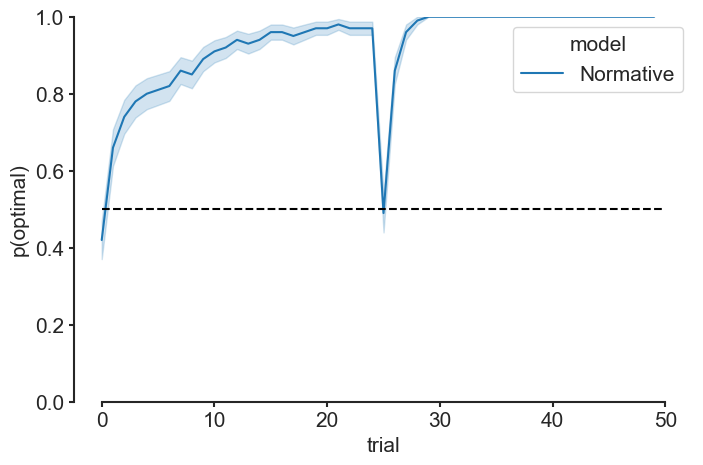

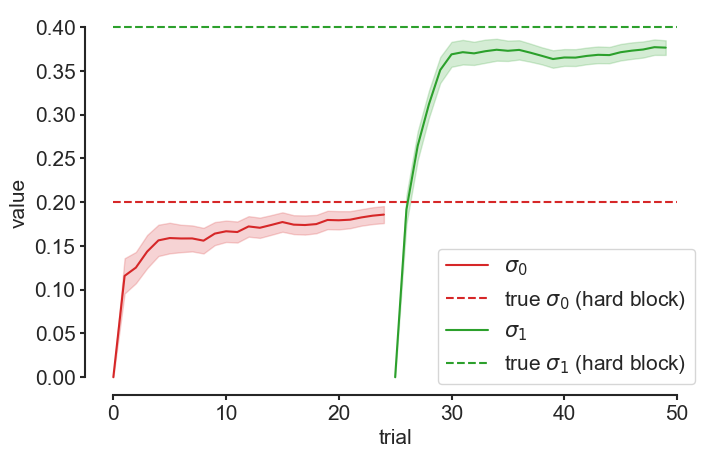

In [30]:
# simulation option value training
# -----------------------------------------------------------------
# parameters to tune
nagents = 100
models = (Normative, )
blocks = [
    [.6, .4],
    [.7, .3]
]
std = .2 
ntrial_per_block = 25

block_idx = np.repeat(
    np.arange(len(blocks)), ntrial_per_block).flatten()

ntrials = len(block_idx)

# data frame to store the results
df = []

# model parameters
normative_param = dict(sigma_prior=.2, temp=1e6)
hybrid_param = dict(perceptual_temp=5, perceptual_model='logit',
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=.5)

params = (normative_param, hybrid_param)

# define progress bar
pbar = tqdm(total=nagents*len(models))
# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
d = []
for agent in range(nagents):
    for model, param in zip(models, params):
        m = model(**param)
        for t in range(ntrials):
            
            s = block_idx[t]
            a = m.make_choice(s, None, None)
            r = tnormrdn(blocks[s][a], std)

            df.append(
                {
                    'trial': t,
                    'model': model.__name__,
                    'agent': agent,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal': a==0,
                    'params': m.get_params(s=s),
                }
            )
            m.learn_value(s, a, r)
        pbar.update()

# refresh progress bar
pbar.refresh()
            
print(np.mean(d))
#----------------------------------------------------------------------------------
# PLOT
#----------------------------------------------------------------------------------
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#  axes width * 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
# increase font size
plt.rcParams.update({'font.size': 15})
sns.set_style('ticks')

df = pd.DataFrame(df)
# add parameters to the dataframe
df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)
# print sigma
# sns.lineplot(x='trial', y='',
sns.lineplot(x='trial', y='optimal', data=df, hue='model', errorbar='se', n_boot=0)
plt.ylabel('p(optimal)')
plt.plot([0, ntrials], [0.5, 0.5], '--', color='k')
plt.ylim(0, 1)
sns.despine(trim=True)
#
plt.figure()
for s in (0, 1):
    sns.lineplot(x='trial', y='σ',
    data=df[(df.model=='Normative') & (df.s==s)], label=f'$\sigma_{s}$', color=['C3', 'C2'][s], n_boot=0, errorbar='se')
    y = blocks[s][0]-blocks[s][1]
    sns.lineplot(x=[0, ntrials], y=[y, ]* 2, ls='--', color=['C3', 'C2'][s], label=f'true $σ_{s}$ (hard block)')
plt.ylabel('value')
# plot true sigma (.2 & .4)
sns.despine(trim=True)

In [ ]:
import numpy as np

num = 800

num = np.float128(num)

AttributeError: module 'numpy' has no attribute 'float128'

# Run full task

In [ ]:
# -----------------------------------------------------------------
# full
# -----------------------------------------------------------------
# parameters to tune
nagents = 1000

models = (NormativeEV, NormativeLogRatio, RandomModel)
blocks = [
    [.6, .4],
    [.7, .3]
]
std = .2 
true_slope = 2

# env parameters
ntrial_per_block = 25
block_idx = np.repeat(
    np.arange(len(blocks)), ntrial_per_block).flatten()
ntrials = len(block_idx)
ff_values = np.linspace(-1, 1, 10).round(1)
ff_p = 1/(1+np.exp(-true_slope*ff_values))


# model parameters
normative_param1 = dict(sigma_prior=.2, slope_prior=true_slope, temp=1e6, x=ff_values, leak=0)
normative_param2 = dict(sigma_prior=.2, slope_prior=true_slope, rl_temp=1e6, perceptual_temp=1e6, 
x=ff_values, leak=.5)

hybrid_param = dict(perceptual_temp=1e6, perceptual_model='logit', x=ff_values,
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=np.mean(blocks))

params = (normative_param1, normative_param2, {})

# data frame to store the results
df = []
# define progress bar
pbar = tqdm(total=nagents*len(models))
# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
for agent in range(nagents):
    for model, param in zip(models, params):
        m = model(**param)
        cumulative_reward = 0
        
        # generate forcefields values and probabilities
        ff1 = np.repeat(ff_values, ntrials/len(ff_values)).flatten()
        ff2 = ff1[:]
        ffp1 = np.repeat(ff_p, ntrials/len(ff_values)).flatten()
        ffp2 = ffp1[:]
        
        # randomize indexes
        order_t1 = np.arange(ntrials)
        order_t2 = np.arange(ntrials)
        np.random.shuffle(order_t1)
        np.random.shuffle(order_t2)

        ff1, ff2, ffp1, ffp2 = ff1[order_t1], ff2[order_t2], ffp1[order_t1], ffp2[order_t2]

        for t in range(ntrials):
            
            # state = s = block index
            s = block_idx[t]

            # make choice
            a = m.make_choice(s, ff1[t], ff2[t])
            
            ffp_chosen = [ffp1[t], ffp2[t]][a]
            ffp_unchosen = [ffp1[t], ffp2[t]][1-a]

            ff_chosen = [ff1[t], ff2[t]][a]
            ff_unchosen = [ff1[t], ff2[t]][1-a]

            destroy = np.random.random() < ffp_chosen

            m.learn_perceptual(ff_chosen, destroy)

            r = 0
            
            if destroy:
                r = tnormrdn(blocks[s][a], std)[0]
                m.learn_value(s, a, r)
                
            optimal_option = a==0
            optimal_ev = (ffp_chosen*blocks[s][a])  > (ffp_unchosen*blocks[s][1-a])
            optimal_ff = ffp_chosen > ffp_unchosen

            cumulative_reward += r

            df.append(
                {
                    'trial': t,
                    'model': str(model.__name__),
                    'agent': agent,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal_option': optimal_option,
                    'optimal_ev': optimal_ev,
                    'optimal_ff': optimal_ff,
                    'choice': ff[a],
                    'params': m.get_params(s=s),
                    'destroy': destroy,
                    'cumulative_reward': cumulative_reward
                }
            )
            
        pbar.update()

df = pd.DataFrame(df)
# unpack parameters
# tqdm.pandas()

# refresh progress bar
pbar.refresh()
print('done')

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\basil\AppData\Local\Temp\ipykernel_11804\1322786783.py:68: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ffp_chosen = [ffp1[t], ffp2[t]][a]
C:\Users\basil\AppData\Local\Temp\ipykernel_11804\1322786783.py:71: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ff_chosen = [ff1[t], ff2[t]][a]
C:\Users\basil\AppData\Local\Temp\ipykernel_11804\1322786783.py:85: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  optimal_ev = (ffp_chosen*blocks[s][a])  > (ffp_unchosen*blocks[s][1-a])
C:\Users\basil\AppData\Local\Temp\ipykernel_11804\1322786783.py:81: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  r = tnormrdn(blocks[s][a], std)[0]
C:\Users\basil\AppData\Local\Temp\ipykernel_11804\2892690953.py:260: RuntimeWarning: overflow encountered in exp
  choice = np.ran

done


Text(0, 0.5, 'cumulative reward - chance')

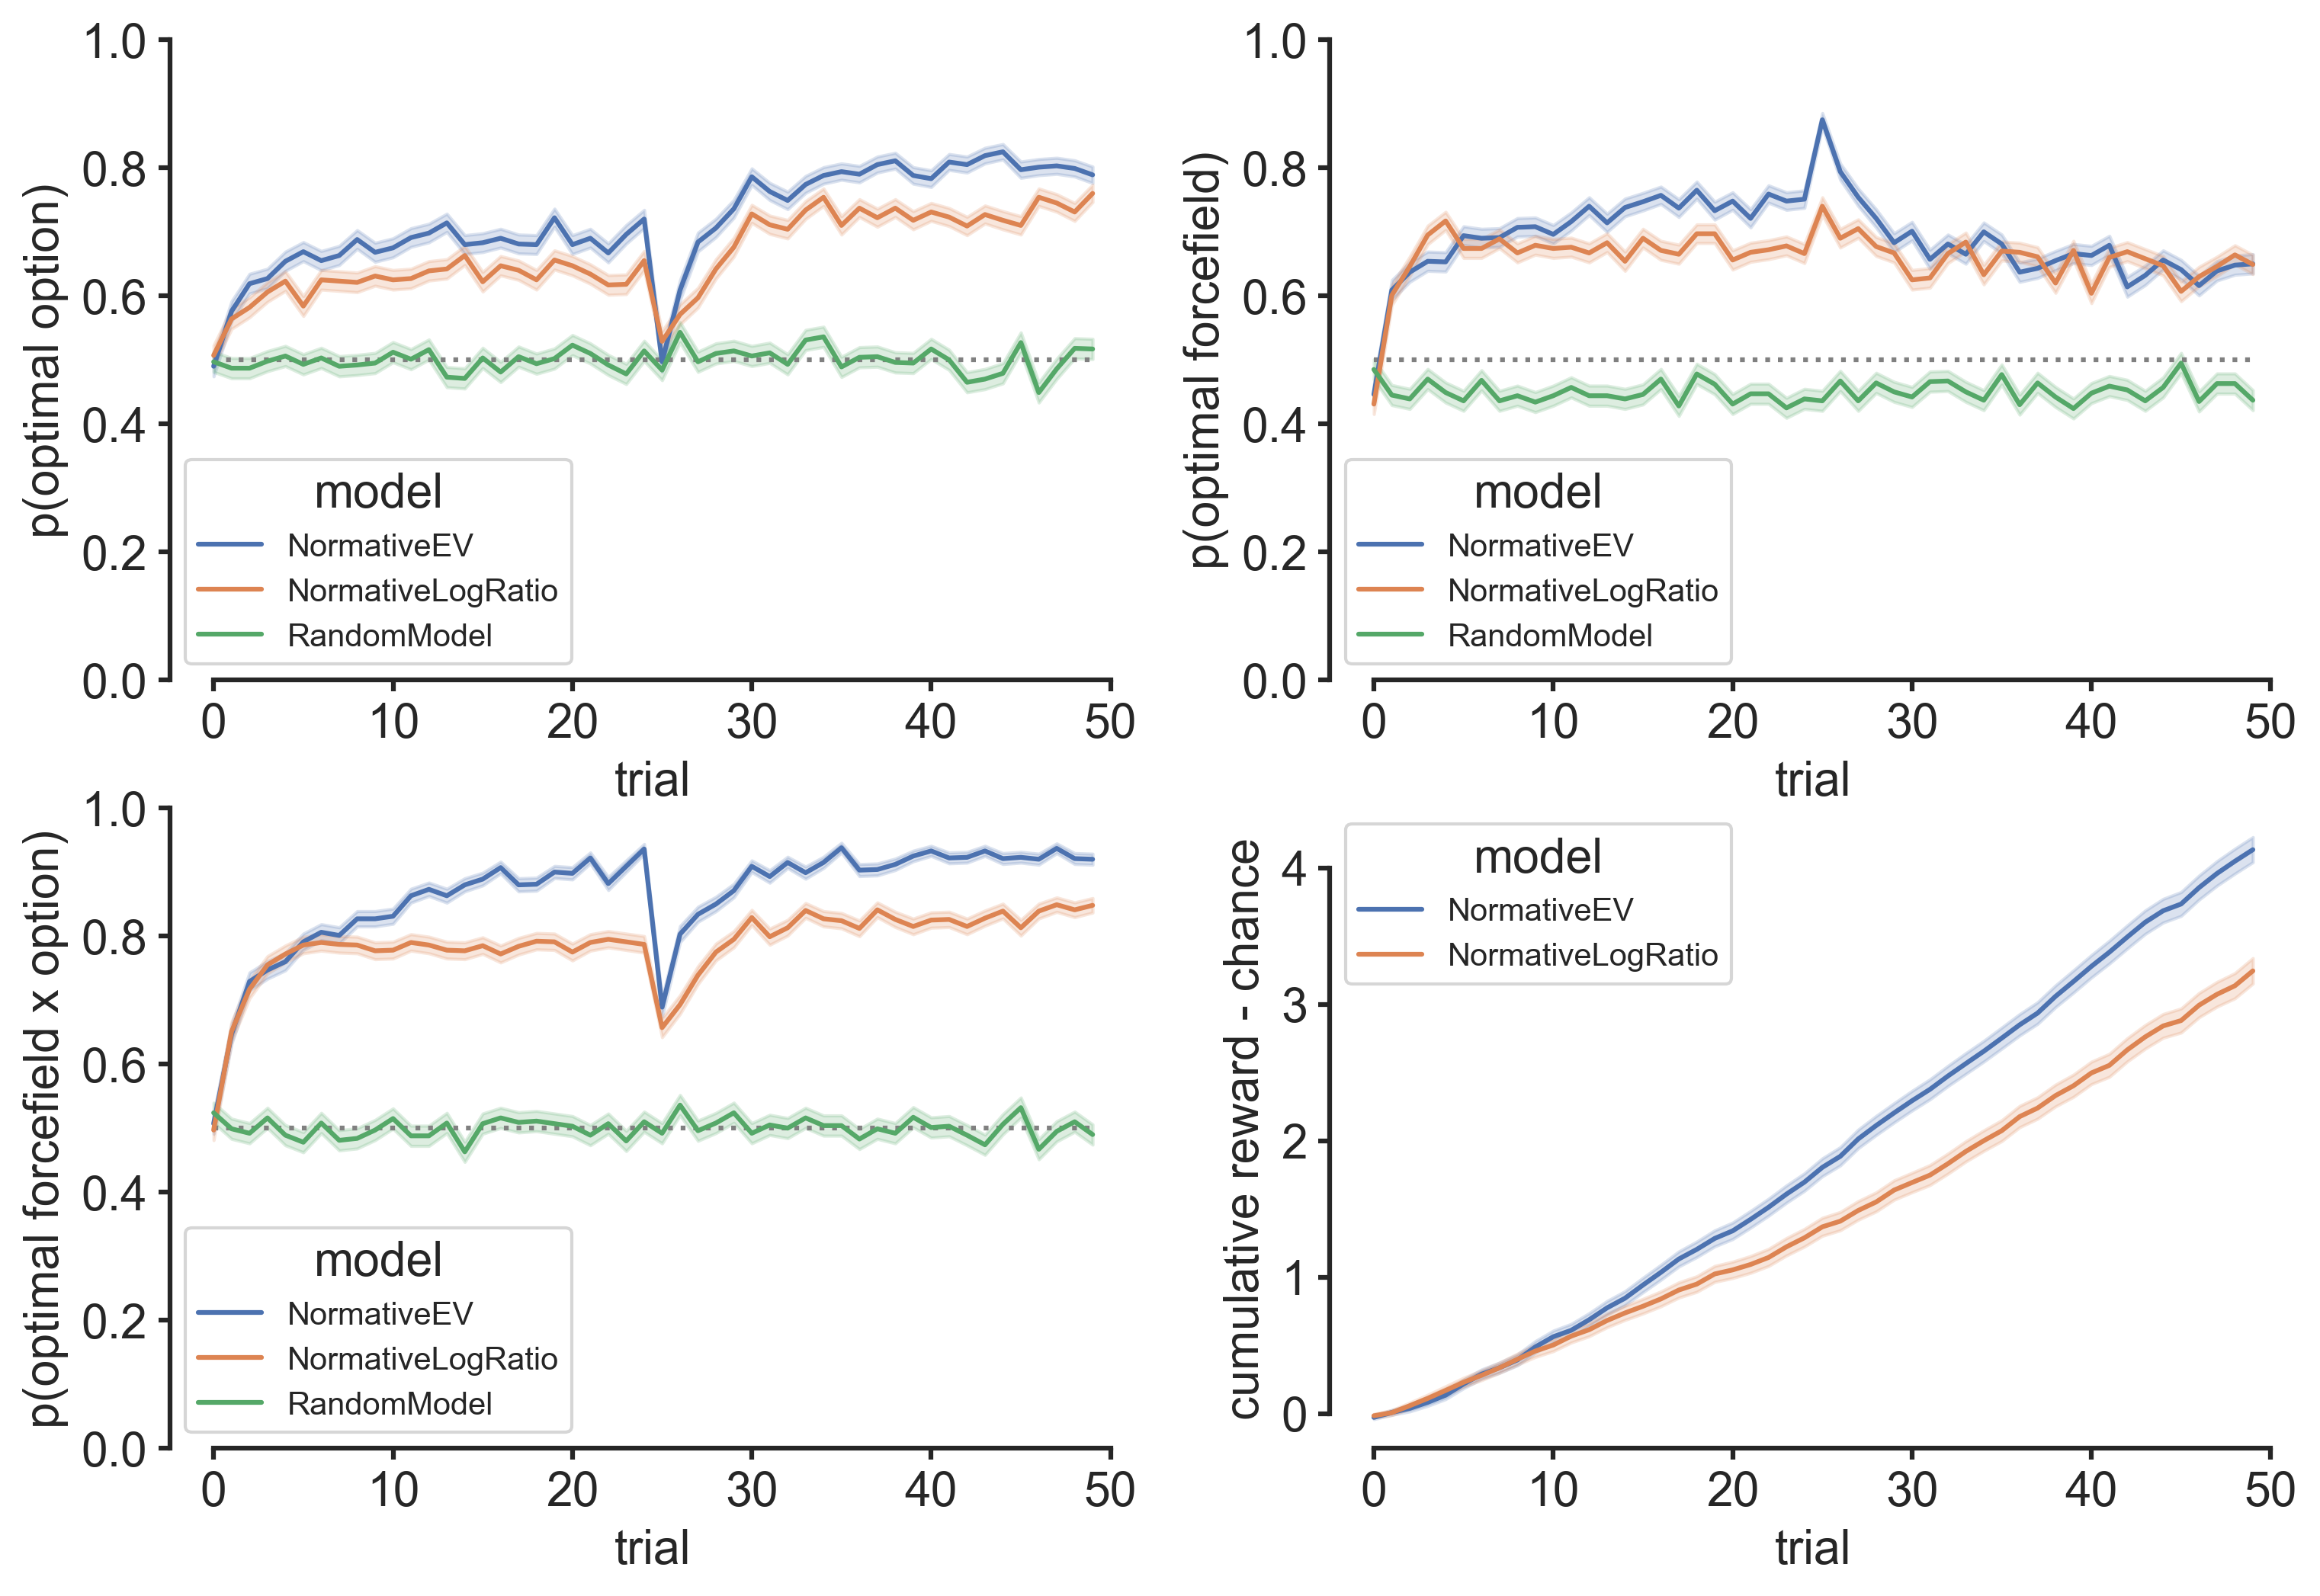

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')
# set legend fontsize
plt.rcParams['legend.fontsize'] = 10
# dpi 300
plt.rcParams['figure.dpi'] = 300

plt.subplot(2, 2, 1)
ntrial = df.trial.max()
# plot dotted line at .5
plt.plot([0, ntrial], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='optimal_option', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(optimal option)')
plt.ylim(0, 1 )
sns.despine(trim=True)

plt.subplot(2, 2, 2)
# plot dotted line at .5
plt.plot([0, ntrial], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='optimal_ff', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(optimal forcefield)')
plt.ylim(0, 1 )
sns.despine(trim=True)

plt.subplot(2, 2, 3)
# plot dotted line at .5
plt.plot([0, ntrial], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='optimal_ev', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(optimal forcefield x option)')
plt.ylim(0, 1 )
sns.despine(trim=True)

plt.subplot(2, 2, 4)
df2 = df.sort_values(['model', 'trial'])
for model in df2.model.unique():
    if model == 'RandomModel':
        continue
    df2.loc[df2.model==model, 'cumulative_reward'] -= df2[df2.model=='RandomModel'].cumulative_reward.values 

# drop random model
df2 = df2[df2.model!='RandomModel']

sns.lineplot(x='trial', y='cumulative_reward', data=df2, hue='model', n_boot=0, errorbar='se')
sns.despine(trim=True)
plt.ylabel('cumulative reward - chance')
# # plt.ylim(0, 1 )




C:\Users\basil\AppData\Local\Temp\ipykernel_11804\3058969259.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = df.groupby(['agent', 'model'], as_index=False).mean()


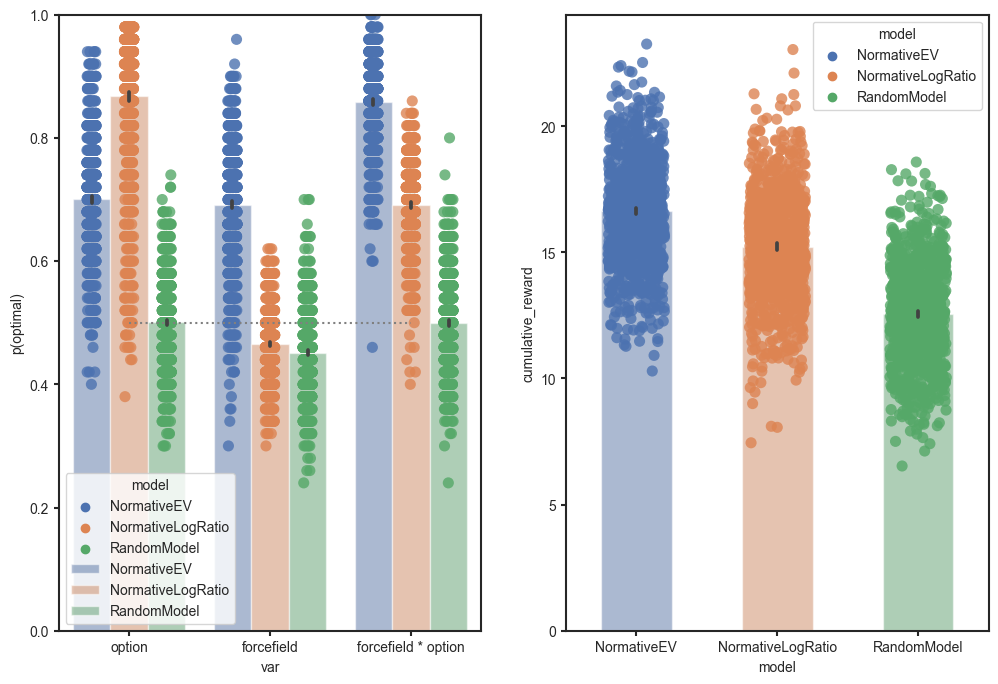

c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\pingouin\parametric.py:252: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\pingouin\effsize.py:803: RuntimeWarning: Mean of empty slice.
  d = (x.mean() - y.mea

ZeroDivisionError: division by zero

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['optimal_option'], avg['optimal_ff'], avg['optimal_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['optimal_option'])
    + ['forcefield',] * len(avg['optimal_ff'])
    + ['forcefield * option',] * len(avg['optimal_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

# replace barplot by distplot with dots
ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(optimal)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield * option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
# plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')

last_trial = df[df['trial'] == df['trial'].max()]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'LogitRLEV']['cumulative_reward'], df[df['model'] == 'NormativeEV']['cumulative_reward'])



In [ ]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [ ]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


In [ ]:
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#  axes width * 1.5 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

sns.set_style('ticks')

if 'params' in df.columns:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

# plot evolution of parameters for each model
plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='NormativeEV'], label='β', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
sns.despine(trim=True)

plt.figure()
mask = df.model == 'LogitRLEV'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
plt.ylabel(('value'))
sns.despine(trim=True)
plt.figure()
sns.lineplot(x='trial', y='σ', data=df[df.model=='NormativeEV'], label='σ', n_boot=0, errorbar='se')
# plot true sigma (.2 & .4)
sns.lineplot(x=[0, ntrials], y=[blocks[0][0] - blocks[0][1]] * 2, ls='--', color='r', label='true σ (block 1)')
sns.lineplot(x=[0, ntrials], y=[blocks[1][0] - blocks[1][1]] * 2, ls='--', color='g', label='true σ (block 2)')
sns.despine(trim=True)